In [3]:
1+1

2

In [119]:
from nltk.tree import Tree, ParentedTree
import nltk
import re

In [347]:
grammar = {}
lexicon = {}
grammar_chomsky = {}

def is_not_POS(x, phrase):
    t = Tree.fromstring(phrase)
    return x in t.leaves()

def remove_leaf(p):
    t = Tree.fromstring(p)
    for w in t.leaves():
        p = p.replace(" " + w, "")
    return p

def remove_function(p):
    return re.sub(r'-[^ ]*', "", p)

def deal_with_P(p):
    return remove_function(remove_leaf(p[2: -1]))

def parcour_tree(t):
    for child in t:
        l.append([t.label(), child.label()])
        parcour_tree(child)
        
def parcour_tree_fin(t):
    lab_cur = remove_function(t.label())
    if isinstance(t[0], str):
        lexicon[t[0]] = lexicon.get(t[0], {})
        lexicon[t[0]][lab_cur] = lexicon[t[0]].get(lab_cur, 0) + 1
        #lexicon.append([remove_function(t.label()), t[0]])
    else:
        child_t = []
        for child in t:
            child_t.append(remove_function(child.label()))
        child_t = tuple(child_t)
        grammar[lab_cur] = grammar.get(lab_cur, {})
        grammar[lab_cur][child_t] =  grammar[lab_cur].get(child_t, 0)+1
        for child in t:
            parcour_tree_fin(child)
            
            
count = [0]
storage = {}
def binarize_tree(t):
    #child = [binarize_tree(child)]
    if isinstance(t[0], str):
        return t
    if len(t)<=2:
        return Tree(t.label(), [binarize_tree(child) for child in t])
    else:
        new_pos = ''
        for child in t[1:]:
            new_pos = new_pos+'|'+child.label()
        new_pos = new_pos[1:]
        return Tree(t.label(), [binarize_tree(t[0]), Tree(new_pos, [binarize_tree(child) for child in t[1:]])])

def remove_function_tree(t):
    if not isinstance(t, str):
        t.set_label(remove_function(t.label()))
        for child in t:
            remove_function_tree(child)
            
        

In [357]:
len(list(t))

3

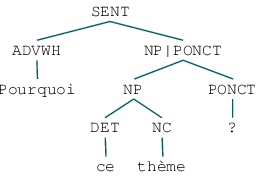

In [349]:
binarize_tree(t)

In [350]:
parcour_tree_fin(binarize_tree(t))
#grammar

In [351]:
grammar

{'SENT': {('ADVWH', 'NP|PONCT'): 1},
 'NP|PONCT': {('NP', 'PONCT'): 1},
 'NP': {('DET', 'NC'): 1}}

In [ ]:
# Chomsky's grammar

def normalize_grammar(g):
    for pos in g.keys():
        count = sum(g[pos].values())
        for key in g[pos].keys():
            g[pos][key] /= count
    return g

#sanity check
print(grammar)
normalize_grammar(grammar)

In [589]:
# Load dataset
#there are 3099 lines in the whole dataset

filepath = '/Users/anneabeille/Documents/MVA/Speech/parser/sequoia-corpus+fct.mrg_strict' 

with open(filepath) as input_file:
    lines=input_file.readlines()
    train = lines[int(len(lines)*0.1):int(len(lines)*0.9)]
    test = lines[int(len(lines)*0.9):]
    val = lines[:int(len(lines)*0.1)]
    
grammar = {}
lexicon = {}

In [591]:
for line in train:
    t = Tree.fromstring(line[2: -2])
    t = binarize_tree(t)
    parcour_tree_fin(t)
    
grammar = normalize_grammar(grammar)

In [595]:
#nombre de règles de la grammaire

number_rules=0
number_unit_rules = 0
for pos in grammar:
    number_rules += len(grammar[pos])
    for key in grammar[pos]:
        if len(key)==1:
            number_unit_rules += 1
print(number_rules)
print(number_unit_rules)

3749
39


In [380]:
def remove_unit_grammar(grammar):
    still_unit = False
    for pos in grammar:
        for key in list(grammar[pos]):
            if len(key)==1:
                proba = grammar[pos].pop(key)
                for new_key in list(grammar.get(key[0], {})):
                    grammar[pos][new_key] = grammar[pos].get(new_key, 0)
                    grammar[pos][new_key] = grammar[pos][new_key] + proba*grammar[key[0]][new_key]
                still_unit = True
    return grammar, still_unit

In [386]:
still_unit_in_g = True
while still_unit_in_g:
    grammar, still_unit_in_g = remove_unit_grammar(grammar)

#need to renormalize
grammar = normalize_grammar(grammar)

In [387]:
print(bool)
#nombre de règles de la grammaire

number_rules=0
number_unit_rules = 0
for pos in grammar:
    number_rules += len(grammar[pos])
    for key in grammar[pos]:
        if len(key)==1:
            number_unit_rules += 1

print(number_rules)

#sanity check
print(number_unit_rules)

False
7929
0


In [596]:
def invert_grammar(g):
    g_inv = {}
    for w, dic in g.items():
        for pos, number in dic.items():
            g_inv[pos] = g_inv.get(pos, {})
            g_inv[pos][w] = number
    return g_inv

lexicon_inv = invert_grammar(lexicon)        
lexicon_inv = normalize_grammar(lexicon_inv)
lexicon_norm = invert_grammar(lexicon_inv)
grammar_inv = invert_grammar(grammar)

In [612]:
### CYK ###
def first_non_terminaux_from_words(s):
    non_term_list = []
    for w in s:
        wdic = lexicon_norm[w]
        nwdic = {k:[v] for (k, v) in wdic.items()}
        add_every_unary(nwdic)
        non_term_list.append(nwdic)
    return non_term_list

def generate_couple(j, i):
    return [[k, i, j-1-k, i+1+k] for k in range(j)]

def iter_cyk(wlistlist):
    pos_list = []
    for i in range(len(wlistlist[-1])-1):
        liste_couple = generate_couple(len(wlistlist), i)
        new_dic = {}
        for couple in liste_couple:
            dic_g = wlistlist[couple[0]][couple[1]]
            dic_d = wlistlist[couple[2]][couple[3]]
            for pos1, v1 in dic_g.items():
                for pos2, v2 in dic_d.items():
                    #inutile maintenant#
                    if not isinstance(v1, float):
                        v1 = v1[0]
                    if not isinstance(v2, float):
                        v2 = v2[0]
                    ### ###
                    for pos_father, proba_trans in grammar_inv.get((pos1, pos2), {}).items():
                        current_proba = new_dic.get(pos_father, [0])[0]
                        if proba_trans*v1*v2 > current_proba:
                            #on a trouvé un meilleur chemin pour pos_father
                            new_dic[pos_father] = [proba_trans*v1*v2, pos1, pos2, couple]       
        # Handling unary rules
        add_every_unary(new_dic)
        #
        
        #on normalise pour éviter les erreurs d'arrondis
        sum_norm = sum(val[0] for val in new_dic.values())
        for pos in new_dic.keys():
            new_dic[pos][0] = new_dic[pos][0]/sum_norm 
        pos_list.append(new_dic)
    return pos_list

def cyk(s):
    l = [first_non_terminaux_from_words(s)]
    while len(l[-1])>1:
        l.append(iter_cyk(l))
    return l

def _create_sub_tree(cyk_list, pos, coordinates, s):
    if len(cyk_list[coordinates[0]][coordinates[1]][pos])==1:
        #on a atteint une feuille
        return Tree(pos, [Tree(s[coordinates[1]], [])]) 
    if len(cyk_list[coordinates[0]][coordinates[1]][pos])==2:
        #unary rule
        npos = cyk_list[coordinates[0]][coordinates[1]][pos][1]
        return Tree(pos, _create_sub_tree(cyk_list, npos, coordinates, s)) 
    pos1 = cyk_list[coordinates[0]][coordinates[1]][pos][1]
    pos2 = cyk_list[coordinates[0]][coordinates[1]][pos][2]
    coordinates1 = cyk_list[coordinates[0]][coordinates[1]][pos][3][:2]
    coordinates2 = cyk_list[coordinates[0]][coordinates[1]][pos][3][2:]
    print(pos1)
    print(pos2)
    print(coordinates1)
    print(coordinates2)
    return Tree(pos, [_create_sub_tree(cyk_list, pos1, coordinates1, s), _create_sub_tree(cyk_list, pos2, coordinates2, s)])

def _tree_from_cyk(cyk_list, s): 
    if cyk_list[-1][0].get('SENT', [0])[0] == 0:
        print("The sentence is not in the grammar")
    else:
        return _create_sub_tree(cyk_list, 'SENT', [len(cyk_list)-1, 0], s)

def tree_from_sentence(s):
    return _tree_from_cyk(cyk(s), s)

In [598]:
### CYK with unary rules : possible to recover the "real" tree

def _add_unary_tab_once(dico):
    still_unit = False
    for pos_from in list(dico.keys()):
        pos_from = (pos_from,)
        for pos_to in list(grammar_inv.get(pos_from, {})):
            if grammar[pos_to][pos_from]*dico[pos_from[0]][0] > dico.get(pos_to, [0])[0]:
                dico[pos_to] = [grammar[pos_to][pos_from]*dico[pos_from[0]][0], pos_from[0]]
                still_unit = True
    return still_unit

def add_every_unary(dico):
    again = True
    while again:
        again = _add_unary_tab_once(dico)

In [600]:
grammar_inv[('NC',)]

{'SENT': 0.0004032258064516129,
 'NP': 0.13471399081041485,
 'AP': 0.000335795836131632}

In [571]:
grammar['NP'][('NC',)]

0.13471399081041485

In [576]:
dic = {'NC': [0.0005794222332588362]}
add_every_unary(dic)
dic

{'NC': [0.0005794222332588362],
 'SENT': [9.190497649484526e-06, 'NP'],
 'NP': [7.805628140658091e-05, 'NC'],
 'AP': [1.945675732904084e-07, 'NC'],
 'PP': [4.778175894134483e-08, 'NP'],
 'COORD': [4.9496690809499624e-08, 'NP']}

NP
VN|PONCT
[1, 0]
[3, 2]
DET
NC
[0, 0]
[0, 1]
VN
PONCT
[2, 2]
[0, 5]
V
NP
[0, 2]
[1, 3]
DET
NC
[0, 3]
[0, 4]


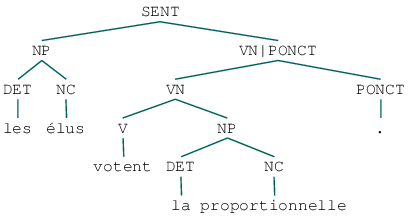

In [602]:
tree_from_sentence(["les", "élus", "votent", 'la', "proportionnelle", "."])

In [564]:
cyk(["les", "élus", "votent", 'la', "proportionnelle", "."])

[[{'DET': [0.10122658040167139], 'CLO': [0.05627705627705628]},
  {'NC': [0.0005794222332588362]},
  {'V': [0.0006447453255963894]},
  {'DET': [0.1678123736352608], 'CLO': [0.04329004329004329]},
  {'NC': [8.277460475126231e-05]},
  {'PONCT': [0.3093607305936073]}],
 [{'NP': [0.12859049498056055, 'DET', 'NC', [0, 0, 0, 1]],
   'DET|NC': [0.8714095050194395, 'DET', 'NC', [0, 0, 0, 1]]},
  {},
  {},
  {'NP': [0.12859049498056055, 'DET', 'NC', [0, 3, 0, 4]],
   'DET|NC': [0.8714095050194395, 'DET', 'NC', [0, 3, 0, 4]]},
  {'NP': [0.00013316465809974033, 'NC', 'PONCT', [0, 4, 0, 5]],
   'NC|PONCT': [0.9998668353419002, 'NC', 'PONCT', [0, 4, 0, 5]]}],
 [{},
  {},
  {'VN': [1.0, 'V', 'NP', [0, 2, 1, 3]]},
  {'NP': [0.0018072575444543974, 'NP', 'PONCT', [1, 3, 0, 5]],
   'SENT': [0.028921794417271093, 'NP', 'PONCT', [1, 3, 0, 5]],
   'NP|PONCT': [0.9692709480382745, 'NP', 'PONCT', [1, 3, 0, 5]]}],
 [{},
  {},
  {'VN': [4.032804189916722e-09, 'V', 'NP', [0, 2, 2, 3]],
   'SENT': [0.00040306327

NP
VN|PONCT
[1, 0]
[3, 2]
DET
NC
[0, 0]
[0, 1]
VN
PONCT
[2, 2]
[0, 5]
V
NP
[0, 2]
[1, 3]
DET
NC
[0, 3]
[0, 4]


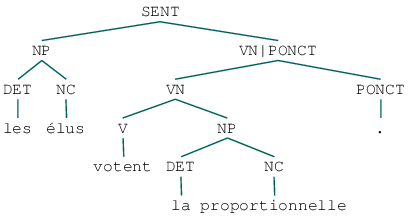

In [506]:
tree_from_cyk(cyk(["les", "élus", "votent", 'la', "proportionnelle", "."]), ["les", "élus", "votent", 'la', "proportionnelle", "."])

In [511]:
sent = """( (SENT (PONCT ") (NP (NPP Paris) (PONCT ,) (NP-MOD (NC ville) (PP (P de) (NP (NC lumière))))) (PONCT !) (PONCT ")))"""

In [603]:
sent_n = ["'" , "Paris", ",", "ville", "de", "lumière", "!", "'"]

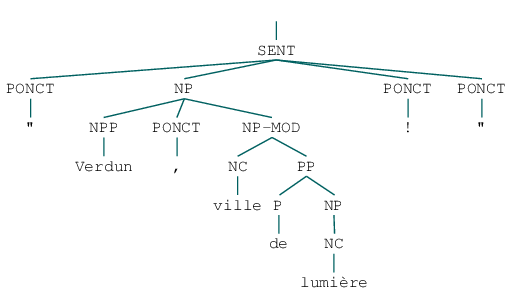

In [518]:
Tree.fromstring(sent)

NP
NP|PONCT
[2, 0]
[4, 3]
PONCT
NPP|PONCT
[0, 0]
[1, 1]
NPP
PONCT
[0, 1]
[0, 2]
NP
PONCT
[3, 3]
[0, 7]
NC
PP
[0, 3]
[2, 4]
P
NP
[0, 4]
[1, 5]
NC
PONCT
[0, 5]
[0, 6]


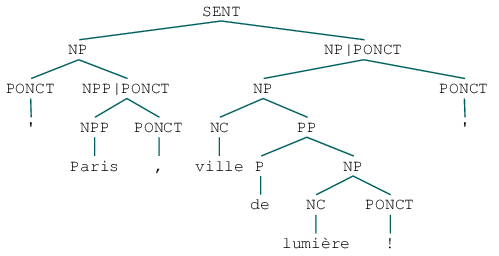

In [604]:
tree_from_sentence(sent_n)

NP
NP|PONCT
[2, 0]
[4, 3]
PONCT
NPP|PONCT
[0, 0]
[1, 1]
NPP
PONCT
[0, 1]
[0, 2]
NP
PONCT
[3, 3]
[0, 7]
NC
PP
[0, 3]
[2, 4]
P
NP
[0, 4]
[1, 5]
NC
PONCT
[0, 5]
[0, 6]


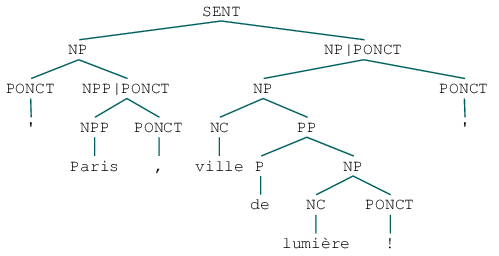

In [523]:
tree_from_sentence(sent_n)

In [476]:
iter_cyk([first_non_terminaux_from_words(["les", "élus", "votent", 'la', "proportionnelle"])])

4
[[0, 0, 0, 1]]
[[0, 1, 0, 2]]
[[0, 2, 0, 3]]
[[0, 3, 0, 4]]


[{'NP': [0.12859049498056055, 'DET', 'NC'],
  'DET|NC': [0.8714095050194395, 'DET', 'NC']},
 {},
 {},
 {'NP': [0.12859049498056055, 'DET', 'NC'],
  'DET|NC': [0.8714095050194395, 'DET', 'NC']}]

In [477]:
iter_cyk(iter_cyk([first_non_terminaux_from_words(["les", "élus", "votent", 'la', "proportionnelle"])]))

4
[[0, 0, 0, 1]]
[[0, 1, 0, 2]]
[[0, 2, 0, 3]]
[[0, 3, 0, 4]]
1
[[0, 0, 3, 1], [1, 0, 2, 2], [2, 0, 1, 3], [3, 0, 0, 4]]


KeyError: 0

In [527]:
grammar_inv[("NC", "PONCT")]

{'NP': 0.00013318239328760737, 'NC|PONCT': 1.0}

In [543]:
grammar  = {}
parcour_tree_fin(binarize_tree(Tree.fromstring("(SENT (NP (NC Nom) (PP (P de) (NP (NC fantaisie)))))")))

In [544]:
grammar

{'SENT': {('NP',): 1},
 'NP': {('NC', 'PP'): 1, ('NC',): 1},
 'PP': {('P', 'NP'): 1}}

In [541]:
grammar = normalize_grammar(grammar)
still_unit_in_g = True
while still_unit_in_g:
    grammar, still_unit_in_g = remove_unit_grammar(grammar)

#need to renormalize
grammar = normalize_grammar(grammar)

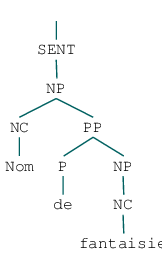

In [529]:
Tree.fromstring("( (SENT (NP (NC Nom) (PP (P de) (NP (NC fantaisie))))))")

NC
PP
[0, 0]
[1, 1]
P
NP
[0, 1]
[0, 2]


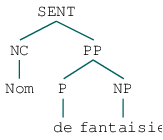

In [613]:
tree_from_sentence(["Nom", "de", "fantaisie"])

In [609]:
cyk(["Nom", "de", "fantaisie"])

[[{'NC': [0.00016554920950252462]},
  {'DET': [0.006874241811564901], 'P': [0.34069178852643417]},
  {'NC': [8.277460475126231e-05]}],
 [{},
  {'NP': [0.002908405142336946, 'DET', 'NC', [0, 1, 0, 2]],
   'DET|NC': [0.01970916968523192, 'DET', 'NC', [0, 1, 0, 2]],
   'PP': [0.00023917702317191792, 'P', 'NC', [0, 1, 0, 2]],
   'P|NC': [0.9767989626341128, 'P', 'NC', [0, 1, 0, 2]],
   'SENT': [0.00034244125062999524, 'NP'],
   'COORD': [1.8442645163836057e-06, 'NP']}],
 [{'NP': [0.0047101628985591745, 'NC', 'NP', [0, 0, 1, 1]],
   'NC|NP': [0.9186041071125081, 'NC', 'NP', [0, 0, 1, 1]],
   'NC|PP': [0.07554277518438436, 'NC', 'PP', [0, 0, 1, 1]],
   'NC|COORD': [0.0005825010190948054, 'NC', 'COORD', [0, 0, 1, 1]],
   'SENT': [0.0005545836961206769, 'NP'],
   'PP': [2.883302459940729e-06, 'NP'],
   'COORD': [2.9867868728973837e-06, 'NP']}]]

{'Amélioration': {'NC': 1}, 'de': {'P': 1}, 'la': {'DET': 1}, 'sécurité': {'NC': 1}, 'Pourquoi': {'ADVWH': 1}, 'ce': {'DET': 1}, 'thème': {'NC': 1}, '?': {'PONCT': 1}}
{'SENT': {('NP',): 1, ('ADVWH', 'NP', 'PONCT'): 1}, 'NP': {('NC', 'PP'): 1, ('DET', 'NC'): 2}, 'PP': {('P', 'NP'): 1}}


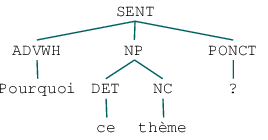

In [339]:
#sanity check
s = "( (SENT (NP (NC Amélioration) (PP (P de) (NP (DET la) (NC sécurité))))))"
s2 = "( (SENT (ADVWH Pourquoi) (NP (DET ce) (NC thème)) (PONCT ?)))"
s3 = "( (SENT (NP (NC Espoir))))"
S = '( (SENT (NP-SUJ (DET Cette) (NC exposition)) (VN (CLO-A_OBJ nous) (V apprend)) (Ssub-OBJ (CS que) (PP-MOD (P dès) (NP (DET le) (ADJ XIIe) (NC siècle))) (PONCT ,) (PP-MOD (P à) (NP (NPP Dammarie-sur-Saulx))) (PONCT ,) (PP-MOD (P entre) (NP (ADJ autres) (NC sites))) (PONCT ,) (NP-SUJ (DET une) (NC industrie) (AP (ADJ métallurgique))) (VN (V existait))) (PONCT .)))'
t = Tree.fromstring(s2[2: -1])
parcour_tree_fin(t)
print(lexicon)
print(grammar)
t

In [ ]:
def binarize_rule(father, children, count):
    new_pos = 'NEW'+str(count)
    p = grammar[father][children]
    grammar_chomsky[father] = grammar_chomsky.get(father, {})
    grammar_chomsky[father][(children[0], new_pos)] = p
    count += 1
    for child in children[1: -2]:
        new_pos = 'NEW'+str(count)
        grammar_chomsky[father][(child, new_pos)] = grammar_chomsky[father].get((child, new_pos), )

def binarize_grammar(g):
    count = 1
    for pos in g.keys():
        for key in g[pos].keys():
            if len(key)>2:
                

In [319]:
t.label()

'SENT'

In [324]:
storage

{('SENT', 'ADVWH'): 'NEW0'}

3749
39


2480

In [88]:
s2 = "(SENT (NP-SUJ (DET Les) (NC enfants)) (VN (V fêtent)) (NP-OBJ (NC saint) (NPP Honoré)))"

In [115]:
t.leaves()

['Une', 'nouvelle', 'école', 'pour', 'la', 'commune']

In [178]:
l1 = []
l2 = []

def is_not_POS(x, phrase):
    t = Tree.fromstring(phrase)
    return x in t.leaves()

def remove_leaf(p):
    t = Tree.fromstring(p)
    for w in t.leaves():
        p = p.replace(" " + w, "")
    return p

def remove_function(p):
    return re.sub(r'-[^ ]*', "", p)

def deal_with_P(p):
    return remove_function(remove_leaf(p[2: -1]))

def parcour_tree(t):
    for child in t:
        l.append([t.label(), child.label()])
        parcour_tree(child)
        
def parcour_tree_fin(t):
    if len(t[0])==0:
        l1.append([remove_function(t.label()), t[0].label()])
    else:
        for child in t:
            l2.append([remove_function(t.label()), remove_function(t[0].label())])

In [177]:
remove_function('ADJ-OBJ ')

'ADJ '

In [14]:
r = t.productions()

In [15]:
r

[SENT -> NP,
 NP -> DET ADJ NC PP,
 DET -> ,
 ADJ -> ,
 NC -> ,
 PP -> P NP,
 P -> ,
 NP -> DET NC,
 DET -> ,
 NC -> ]

In [62]:
for u in t.subtrees():
    print(u)

(
  (SENT
    (NP
      (DET Une)
      (ADJ nouvelle)
      (NC école)
      (PP (P pour) (NP (DET la) (NC commune))))))
(SENT
  (NP
    (DET Une)
    (ADJ nouvelle)
    (NC école)
    (PP (P pour) (NP (DET la) (NC commune)))))
(NP
  (DET Une)
  (ADJ nouvelle)
  (NC école)
  (PP (P pour) (NP (DET la) (NC commune))))
(DET Une)
(ADJ nouvelle)
(NC école)
(PP (P pour) (NP (DET la) (NC commune)))
(P pour)
(NP (DET la) (NC commune))
(DET la)
(NC commune)


In [9]:
t = [Tree.fromstring("( (SENT (PP (P) (NP (DET) (NC) (PP (P) (NP (NC))))) (PONCT)))"),
Tree.fromstring("(SENT (NP (DET) (ADJ) (NC) (PP (P) (NP (DET) (NC)))))")]

In [10]:
t.productions()

AttributeError: 'list' object has no attribute 'productions'

In [123]:
re.sub(r'-[^ ]*', "", "abfhghfdbf-azaz dzdz")

'abfhghfdbf dzdz'